tobac example: Tracking deep convection based on OLR from geostationary satellite retrievals
==

This example notebook demonstrates the use of tobac to track isolated deep convective clouds based on outgoing longwave radiation (OLR) calculated based on a combination of two different channels of the GOES-13 imaging instrument.

The data used in this example is downloaded from "zenodo link" automatically as part of the notebooks (This only has to be done once for all the tobac example notebooks).

In [1]:
# Import a range of python libraries used in this notebook:
import datetime
import shutil
from pathlib import Path
from six.moves import urllib

import numpy as np
import pandas as pd
import xarray as xr

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Import tobac itself:
import tobac
print('using tobac version', str(tobac.__version__))

using tobac version 1.5.5


In [3]:
# Disable a few warnings:
import warnings
warnings.filterwarnings('ignore', category=UserWarning, append=True)
warnings.filterwarnings('ignore', category=RuntimeWarning, append=True)
warnings.filterwarnings('ignore', category=FutureWarning, append=True)
warnings.filterwarnings('ignore',category=pd.io.pytables.PerformanceWarning)

**Download example data:**   
This has to be done only once for all tobac examples.

In [4]:
data_out=Path('../')

In [5]:
# Download the data: This only has to be done once for all tobac examples and can take a while
data_file = list(data_out.rglob('data/Example_input_OLR_satellite.nc'))
if len(data_file) == 0:
    file_path='https://zenodo.org/records/3195910/files/climate-processes/tobac_example_data-v1.0.1.zip'
    #file_path='http://zenodo..'
    tempfile=Path('temp.zip')
    print('start downloading data')
    request=urllib.request.urlretrieve(file_path, tempfile)
    print('start extracting data')
    shutil.unpack_archive(tempfile, data_out)
    tempfile.unlink()
    print('data extracted')
    data_file = list(data_out.rglob('data/Example_input_OLR_satellite.nc'))

**Load data:**

In [6]:
#Load Data from downloaded file:
OLR = xr.open_dataset(data_file[0]).olr

In [7]:
# Display information about the input data cube:
display(OLR)

<xarray.DataArray 'olr' (time: 54, lat: 131, lon: 184)> Size: 10MB
[1301616 values with dtype=float64]
Coordinates:
  * time     (time) datetime64[ns] 432B 2013-06-19T19:02:22 ... 2013-06-20T02...
  * lat      (lat) float64 1kB 28.03 28.07 28.11 28.15 ... 32.92 32.96 32.99
  * lon      (lon) float64 1kB -94.99 -94.95 -94.91 ... -88.08 -88.04 -88.01
Attributes:
    long_name:  OLR
    units:      W m^-2

In [8]:
#Set up directory to save output and plots:
savedir=Path("Save")
if not savedir.is_dir():
    savedir.mkdir()
plot_dir=Path("Plot")
if not plot_dir.is_dir():
    plot_dir.mkdir()

**Data visualisation**

We can take a look at our data both by plotting an individual time step, and by plotting a histogram of the values as shown below:

Visualising the data like this can help make suitable choices for the parameters used in the detection and tracking of features. In this dataset, we can see that the background values range from 300 Wm-2, while the coldest features peak around 150 Wm-2

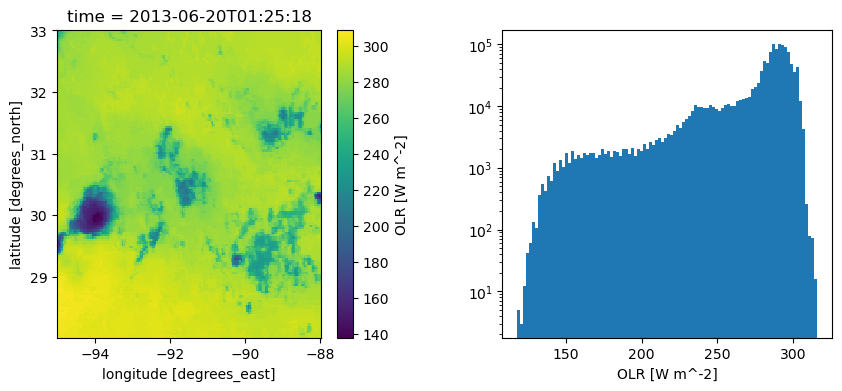

In [9]:
plt.figure(figsize=(10,4))

ax1 = plt.subplot(1,2,1)
OLR[42].plot(ax=ax1)

ax2 = plt.subplot(1,2,2)
OLR.plot(ax=ax2, bins=100)
plt.yscale("log")

plt.subplots_adjust(wspace=0.35)

**Feature identification:**  
Identify features based on OLR field and a set of threshold values

In [10]:
# Determine temporal and spatial sampling of the input data:
dxy, dt = tobac.get_spacings(OLR, grid_spacing=4000)

In [11]:
# Keyword arguments for the feature detection step
parameters_features={}
parameters_features['position_threshold']='weighted_diff'
parameters_features['sigma_threshold']=0.5
parameters_features['n_min_threshold']=4
parameters_features['target']='minimum'
parameters_features['threshold']=[250,225,200,175,150]

In [12]:
# Feature detection and save results to file:
print('starting feature detection')
Features=tobac.feature_detection_multithreshold(OLR,dxy,**parameters_features)
Features.to_hdf(savedir / 'Features.h5','table')
print('feature detection performed and saved')


starting feature detection
feature detection performed and saved


Feature detection returns a dataframe containing information about each detected object, as shown below:

In [13]:
Features.head()

,frame,idx,hdim_1,hdim_2,num,threshold_value,feature,time,timestr,lat,lon
0,0,1,2.574109,154.214477,9,250,1,2013-06-19 19:02:22,2013-06-19 19:02:22,28.131008,-89.103851
1,0,3,3.354292,162.980569,9,250,2,2013-06-19 19:02:22,2013-06-19 19:02:22,28.160780,-88.769332
2,0,8,37.479003,146.971379,6,250,3,2013-06-19 19:02:22,2013-06-19 19:02:22,29.462995,-89.380251
3,0,22,106.638010,145.251412,14,250,4,2013-06-19 19:02:22,2013-06-19 19:02:22,32.102135,-89.445885
4,0,24,108.354401,152.894109,7,250,5,2013-06-19 19:02:22,2013-06-19 19:02:22,32.167634,-89.154237


We can also compare the detected features to the input field to judge whether feature detection has done a good job. Below, we can see that the use of multiple thresholds has allowed the most prominent features (blue) to be detected, as well as less prominent features surrounding them which may represent earlier stages of convective storms

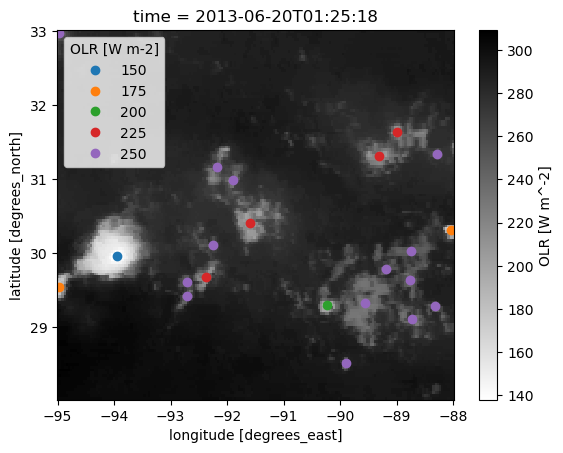

In [14]:
frame=42
OLR[frame].plot(cmap="binary")
points = {
    threshold:plt.plot(ft.lon, ft.lat, "o")[0]
    for threshold, ft in Features[Features.frame==frame].groupby("threshold_value")
}
plt.legend(list(points.values()), list(points.keys()), title="OLR [W m-2]")

**Segmentation:**  
The segmentation step is performed to find an area of the input domain that is associated with each detected feature. Segmentation is performed with watershedding based on the detected features and a single threshold value. Unlike feature detection, the watershed operation can distinguish objects which neighbour one another when dividing the domain. Segmentation returns both a mask, with the same dimensions as the input field, showing the region associated with each feature, along with an updated dataframe with information about the segments.

In [15]:
# Keyword arguments for the segmentation step:
parameters_segmentation={}
parameters_segmentation['target']='minimum'
parameters_segmentation['method']='watershed'
parameters_segmentation['threshold']=250

In [16]:
# Perform segmentation and save results:
print('Starting segmentation based on OLR.')
Mask_OLR, Features_OLR = tobac.segmentation_2D(Features, OLR, dxy, **parameters_segmentation)
print('segmentation OLR performed, start saving results to files')
Mask_OLR.to_netcdf(savedir / 'Mask_Segmentation_OLR.nc', encoding={"segmentation_mask":{"zlib":True, "complevel":4}})
Features_OLR.to_hdf(savedir / 'Features_OLR.h5', 'table')
print('segmentation OLR performed and saved')

Starting segmentation based on OLR.
segmentation OLR performed, start saving results to files
segmentation OLR performed and saved


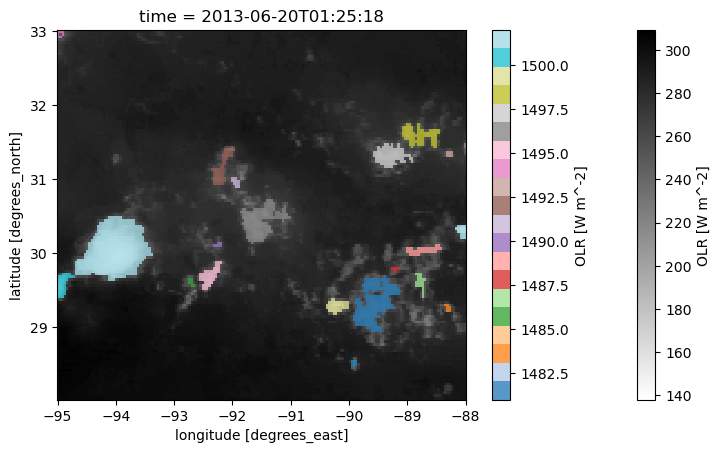

In [17]:
plt.figure(figsize=(8.8, 4.8))
OLR[frame].plot(cmap="binary", cbar_kwargs=dict(pad=0.1))
Mask_OLR[frame].where(Mask_OLR[frame]>0).plot(cmap="tab20", alpha=0.75)

**Trajectory linking:**  
The detected features are linked into cloud trajectories using the trackpy library (http://soft-matter.github.io/trackpy). This takes the feature positions determined in the feature detection step into account but does not include information on the shape of the identified objects.

In [18]:
# keyword arguments for linking step
parameters_linking={}
parameters_linking['v_max']=20
parameters_linking['stubs']=2
parameters_linking['order']=1
parameters_linking['extrapolate']=0
parameters_linking['memory']=0
parameters_linking['adaptive_stop']=0.2
parameters_linking['adaptive_step']=0.95
parameters_linking['subnetwork_size']=100
parameters_linking['method_linking']= 'predict'

In [19]:
# Perform linking and save results to file:
Track=tobac.linking_trackpy(Features,OLR,dt=dt,dxy=dxy,**parameters_linking)
Track.to_hdf(savedir / 'Track.h5','table')

Frame 53: 11 trajectories present.


**Visualisation:**  

In [20]:
# Set extent of maps created in the following cells:
axis_extent=[-95,-89,28,32]        

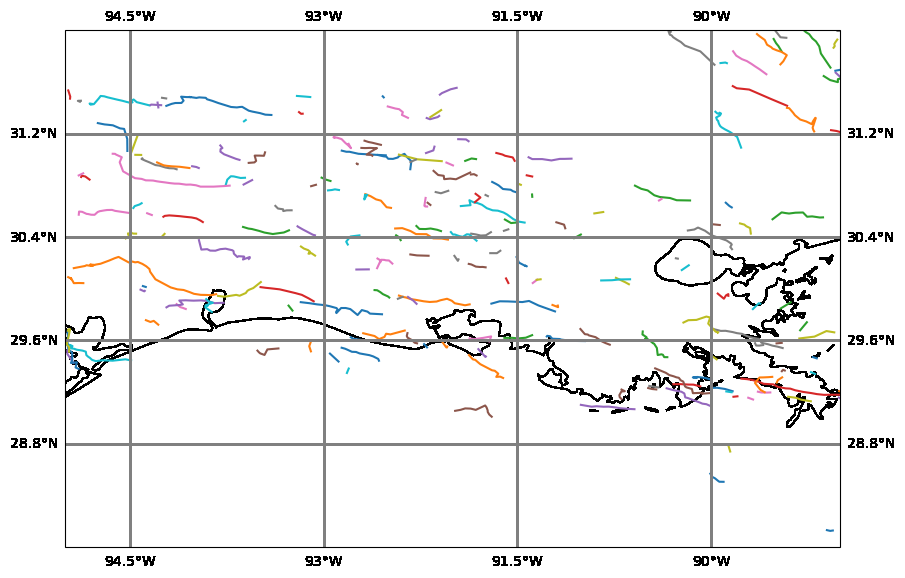

In [21]:
# Plot map with all individual tracks:
import cartopy.crs as ccrs
fig_map,ax_map=plt.subplots(figsize=(10,10),subplot_kw={'projection': ccrs.PlateCarree()})
ax_map=tobac.map_tracks(Track,axis_extent=axis_extent,axes=ax_map)

Text(0, 0.5, 'counts')

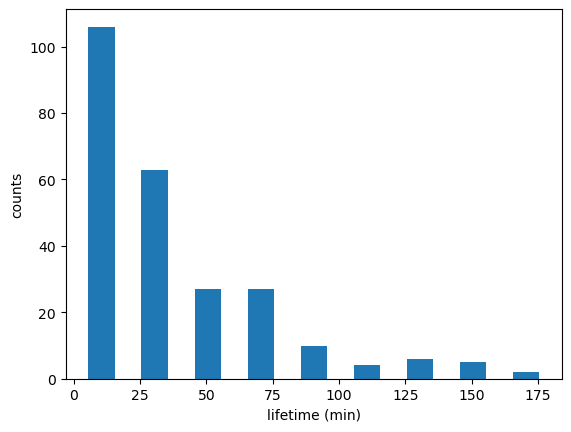

In [22]:
# Lifetimes of tracked clouds:
fig_lifetime,ax_lifetime=plt.subplots()
tobac.plot_lifetime_histogram_bar(Track,axes=ax_lifetime,bin_edges=np.arange(0,200,20),density=False,width_bar=10)
ax_lifetime.set_xlabel('lifetime (min)')
ax_lifetime.set_ylabel('counts')
         

In [23]:
# Create animation of tracked clouds and outlines with OLR as a background field
animation_test_tobac=tobac.animation_mask_field(
    Track, Features, OLR, Mask_OLR,
    axis_extent=axis_extent,
    vmin=80, vmax=330,
    plot_outline=True, plot_marker=True, marker_track='x',
    plot_number=True, plot_features=True
)

In [24]:
# Display animation:
from IPython.display import HTML, Image, display
HTML(animation_test_tobac.to_html5_video())

<Figure size 640x480 with 0 Axes>